# Ornstein-uhlenbeck model fitting test environement

With the idea of exploring how the theory can be applied to real historic data a proof-of-concept is shown here where limited historic data is used:
1) To create a stationary portfolio
2) To fit Ornstein-uhlenbeck model to the data

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

In [2]:
price_data  = pd.read_csv('yfinance_bel20_data_1h.csv').set_index('Datetime')
price_data = price_data.iloc[100:].dropna(axis=0)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns#[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [578]:
price_data  = pd.read_csv('futures_data_6h.csv').set_index('close_time')
price_data = price_data.iloc[2000:].dropna(axis=1)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns#[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [471]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 100, loadings_window_size:int=50, amount_of_factors:int=3):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [580]:
def pca_limited(returns:pd.DataFrame, rebalance_speed=15, res_cov_window_size:int = 60, loadings_window_size:int=30, amount_of_factors:int=3):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    begin = min(rebalance_speed, res_cov_window_size)
    epochs = int(len(returns) // rebalance_speed)

    for epoch in range(1,epochs-1):
        # only use the columns with no missing values
        if epoch*rebalance_speed- res_cov_window_size < 0:
            continue
        idxsSelected = ~np.any(np.isnan(returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed,idxsSelected]
        R_oos           = returns[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos.T
        residuals_output[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected]                = residuals.T
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [581]:
test                      = pct_ret
PCA, pca_portfolio        = pca_limited(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [576]:
rebalance_times = list(range(1,60))
result_cost = list()
result_kappa = list()
result_r2 = list()

for time in rebalance_times:
    print(time)
    PCA, pca_portfolio        = pca_limited(test,rebalance_speed=time) 
    avg_change= (np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()
    T, N = PCA.shape
    kappas = list()
    R2s    = list()
    for idx in range(N):
        kappa, _,_,_,R2 = estimate_coefficients_LR((PCA[:,idx]+1).cumprod(),T)
        kappas.append(kappa)
        R2s.append(R2)
    result_kappa.append(sum(kappas)/N)
    result_r2.append(sum(R2s)/N)
    result_cost.append(avg_change)    

1


2
3
4


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


5


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


6
7
8


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


9


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


10
11
12


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


13


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


14
15


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


16


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


17


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


18
19


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


20
21


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


22


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


23


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigm

24


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


25


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigm

26


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


27


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


28


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


29
30
31


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


32
33
34
35


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


36
37
38
39


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


40
41


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


42
43


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigm

44


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


45


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


46


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


47


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


48


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


49


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigm

50


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


51


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


52


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


53
54


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


55


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


56


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


57
58


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


59


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:18: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.var(data)*2*kappa)
/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_15348/4273217280.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = sigma / np.sqrt(2*kappa)


Text(0, 0.5, '$\\kappa$ from OU-fit')

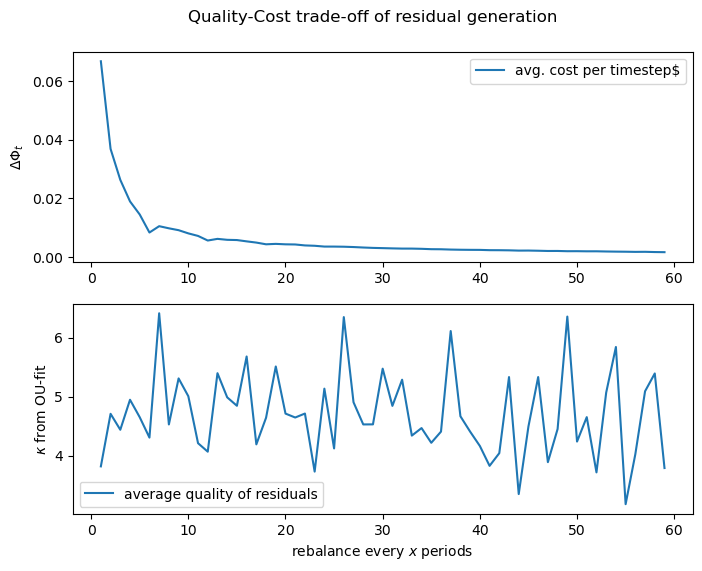

In [577]:
fig, ax = plt.subplots(2,1,figsize=(8,6),dpi=100)
#plt.tight_layout()
plt.suptitle('Quality-Cost trade-off of residual generation',y=0.95)
# plot a sample path of the wealth
ax[0].plot(rebalance_times, result_cost)
ax[0].legend([r'avg. cost per timestep$'])
ax[0].set_ylabel(r'$\Delta\Phi_t$')
ax[1].set_xlabel(r'rebalance every $x$ periods')
#ax[0].set_xlabel('Time')
ax[1].plot(rebalance_times,result_kappa)
ax[1].legend([r'average quality of residuals'])
ax[1].set_ylabel(r'$\kappa$ from OU-fit')
#ax[2].plot(rebalance_times,result_r2)
#ax[2].legend([r'$R^2$ of OU fit'])


Text(0.5, 1.0, 'Correlation matrix of the residuals')

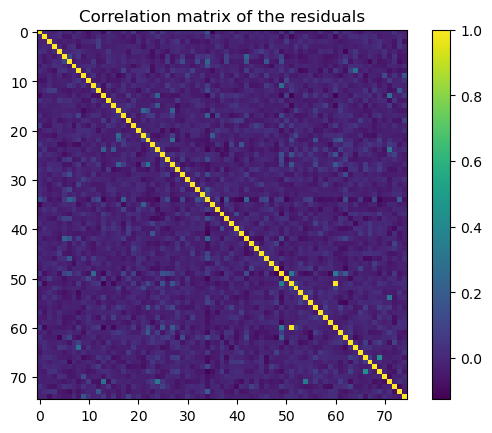

In [582]:
ax1 = plt.imshow(residuals.corr(),)
plt.colorbar(ax1)
plt.title('Correlation matrix of the residuals')

Text(0.5, 1.0, 'Residuals created for selected BEL20 stocks, rebalanced every timestep')

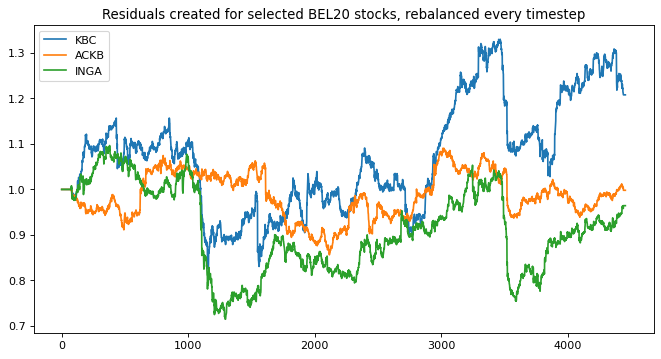

In [574]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((residuals[['KBC.BR','ACKB.BR','INGA.AS']].values+1).cumprod(axis=0))
plt.legend(['KBC','ACKB','INGA'])
plt.title('Residuals created for selected BEL20 stocks, rebalanced every timestep')

In [587]:
def preprocess_ou(data:np.array, lookback:int=40):
    #print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    #print("Finish OU preprocess")
    return windows, idxs_selected

Text(0.5, 1.0, 'SCREE plot of eigenvalues')

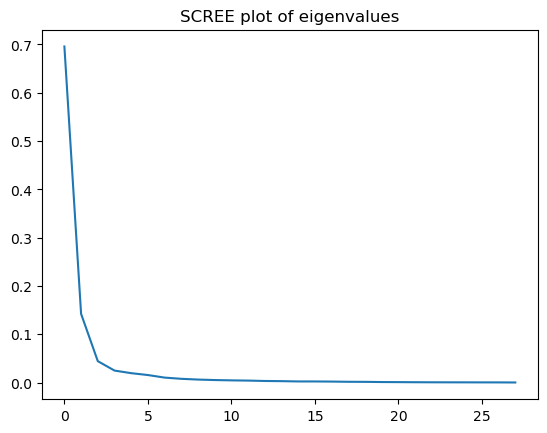

In [563]:
plt.plot(np.flip(eigenValues / eigenValues.sum()))
plt.title('SCREE plot of eigenvalues')

In [123]:
def estimate_coefficients_LR(data, LOOKBACK_PERIOD):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Linear regression method'''
    #fitting the model
    X = data[:-1].reshape(-1,1)
    y = data[1:]
    model2 = LinearRegression().fit(X,y)
    a = model2.intercept_
    b = model2.coef_
    pred = model2.predict(X)
    score = model2.score(X,y)
    zeta = y - pred
    # OU parameters 
    #b = 1e-6 if b < 0 else b
    kappa = -np.log(b) * LOOKBACK_PERIOD
    m = a/(1-b)
    sigma = np.sqrt(np.var(data)*2*kappa)
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa[0], m[0], sigma[0], sigma_eq[0], score

In [164]:
import scipy.optimize as so
def compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)
    m_i, kappa, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * np.exp(-kappa * dt) - m_i * (1 - np.exp(-kappa * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-np.log(2 * np.pi) / 2) + (-np.log(np.sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood

def estimate_coefficients_MLE(X, dt, tol=1e-14):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # m_i ∈ ℝ, kappa > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    m_init = np.mean(X)
    initial_guess = (m_init, 0, 1)  # initial guesses for m_i, kappa, sigma
    result = so.minimize(compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds, tol=tol)
    m, kappa, sigma = result.x 
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa, m, sigma, sigma_eq, np.exp(result.fun)

In [688]:
estimate_coefficients_LR(oos_residuals[8,:],2)

(5.408001226498459,
 0.00018289967393843995,
 0.009576430541885993,
 0.0029118585512241894,
 0.00449535723842065)

In [689]:
estimate_coefficients_MLE(is_residuals[8,:], 1, tol=1e-10)

(10.050251579107226,
 8.038826926865727e-06,
 0.01532019994076198,
 0.0034171258104756866,
 0.01412206756038556)

In [781]:
#finding factors using RP-PCA
gamma = 20
T,N = is_returns.shape
res_mean = np.mean(is_returns,axis=0,keepdims=True)
RPPCA_matrix = 1/T * is_returns.T @ is_returns + gamma * res_mean @ res_mean.T
eigenValues, eigenVectors = np.linalg.eigh(RPPCA_matrix)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
R           = is_returns
wtR         = is_returns @ w                  # R * w 
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ w.T)

is_residuals   = phi @ R.T
oos_residuals  = phi @ oos_returns.T